# <font > Monte Carlo approach to price Binary options <font>

## How to use the scripts

## Below is a detailed explanation of the approach with the full kernel

Monte Carlo simulation is one of the numerical methods which can be used to price options and is especially useful when closed-form solutions can be difficult to find and/or models/contracts are complex or difficult to evaluate. The Monte Carlo approach can simulate the entire path of the options and can be extremely efficient in incorporating complex path dependencies.
The different steps used in the Monte Carlo approach to price options are outlined below:[<sup>1</sup>](#fn1)

1.	The first step involves simulating the path of the underlying under a risk neutral random walk. Starting with the initial price S0 of the underlying, the idea is to arrive at a final price S using a discretized form of the stochastic differential equation for the underlying, also known as the Euler Maruyama method[<sup>2</sup>](#fn2). It's of the form: $\delta$S=rS$\delta$t+$\sigma$S$\sqrt{\delta t}$$\phi$, where $\phi$ is obtained from a standardized Normal distribution

2.	The simulations are repeated N number of times.

3.	The payoffs of the option under each simulation are calculated and averaged. In case of binary options, the payoff is calculated using the Heaviside function[<sup>3</sup>](#fn3), which gives an option pay-off of 1 if the option is in the money and 0 otherwise. It's mathematically represented as: 

\begin{equation*}
\mathcal{H}\left( x\right) :=\left\{ 
\begin{array}{c}
1,  \\ 
0, 
\end{array}
\begin{array}{c}
x>0 \\ 
x<0
\end{array}
\right.
\end{equation*}

4.	The average payoff is then discounted using the risk-free rate to get the option price.


## Implementation

In [3]:
#Import libraries

import pandas as pd
import numpy as np

import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm,ttest_ind
import datetime
import tqdm

In [20]:
np.random.seed(1)

In [52]:
#Initial parameters

S0=100 #Current price of the underlying
E=100 #Strike price
r=0.05 #Constant Risk-free rate
sigma=0.2 #Volatility
T=1 #Time to expiry in yrs

dt=0.01 #Time step used in the MC simulation
N=100 #No. of simulations


In [1287]:
#Monte Carlo class

class MC:
        
    def __init__(self,spot,strike,r,sigma,tou,dt,N):
        self.spot=spot
        self.strike=strike
        self.r=r
        self.tou=tou
        self.sigma=sigma
        self.dt=dt
        self.N=N
        self.n=int(self.tou/self.dt)
    
    def simulate(self):
        np.random.seed(1)
        S={}
        for k in range(self.N):
            S[k+1,0]=self.spot
            for i in range(self.n):
                #Euler method to simulate the entire path
                S[k+1,i+1]=S[k+1,i]+(self.r*S[k+1,i]*self.dt)+(np.sqrt(self.dt)*S[k+1,i]*self.sigma*norm.ppf(np.random.rand()))

        Sf=pd.DataFrame.from_dict(S,orient='index').rename(columns={0:'S'})
        Sf=Sf.reset_index()
        Sf['sim']=Sf['index'].apply(lambda x:x[0])
        Sf['t']=Sf['index'].apply(lambda x:x[1])
        Sf=Sf.pivot(index='t',columns='sim')['S']
        
        return Sf

    def plot(self):
        Sf=self.simulate()
        
        ax=Sf.plot(figsize=(25,10),legend=False,colormap='viridis')
        ax.set_xlabel('No. of timesteps',color='brown')
        ax.set_ylabel('Price of Underlying',color='brown')
        ax.margins(x=0)

    def payoffs(self):
        Sf=self.simulate()
        final=Sf.T.iloc[:,-1].reset_index()

        #Payoffs
        final['payoff_c']=final[self.n].apply(lambda x:max(x-self.strike,0))
        final['payoff_p']=final[self.n].apply(lambda x:max(self.strike-x,0))

        final['payoff_bc']=final[self.n].apply(lambda x:1 if x-self.strike>0 else 0)
        final['payoff_bp']=final[self.n].apply(lambda x:1 if x-self.strike<0 else 0)
        
        return final
    
    def callPrice(self):
        
        final=self.payoffs()
        call=final.payoff_c.mean()*np.exp(-self.r*(self.tou))
        
        return call

    def putPrice(self):
        
        final=self.payoffs()
        put=final.payoff_p.mean()*np.exp(-self.r*(self.tou))
        
        return put

    def binarycallPrice(self):
        
        final=self.payoffs()
        bcall=final.payoff_bc.mean()*np.exp(-self.r*(self.tou))
        
        return bcall
    
    def binaryputPrice(self):
        
        final=self.payoffs()
        bput=final.payoff_bp.mean()*np.exp(-self.r*(self.tou))
        
        return bput


Chart 1 : MC Simulations using the Euler Maruyama method


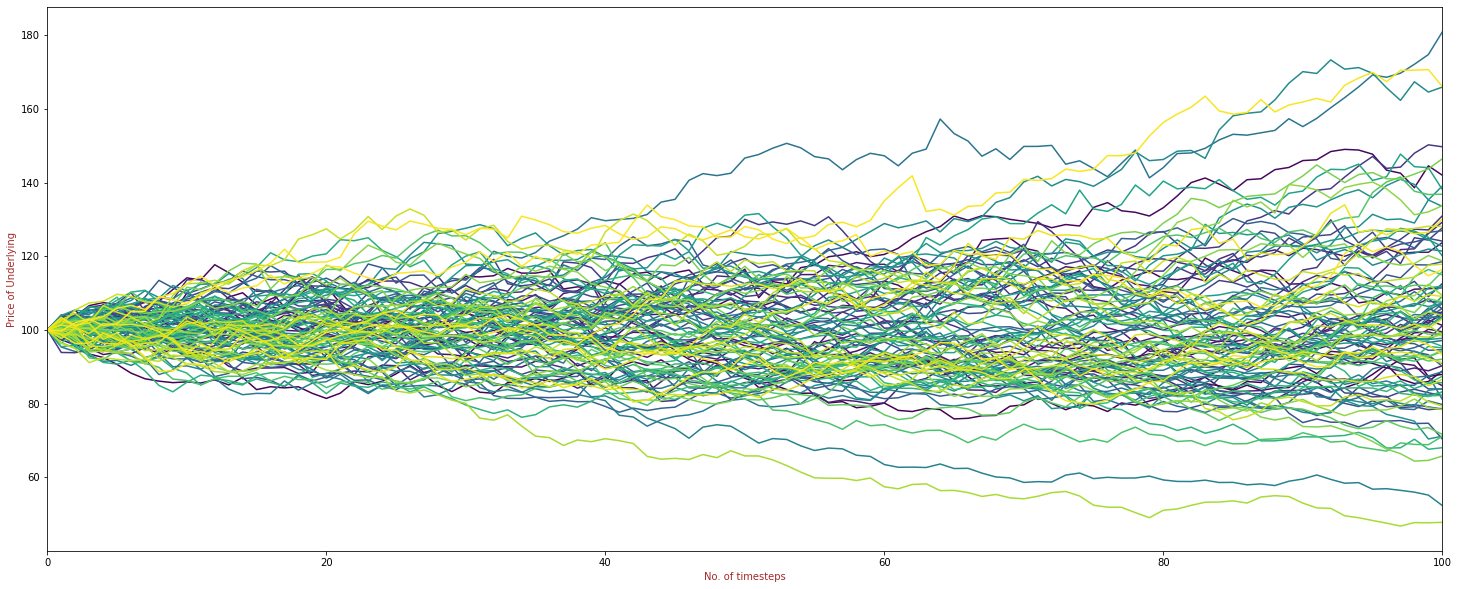

In [1288]:
# Simulation of the paths (with 100 simulations) 
print('\nChart 1 : MC Simulations using the Euler Maruyama method')
MC(S0,E,r,sigma,T,dt,100).plot()


Chart 2 : Distribution of the final simulated prices


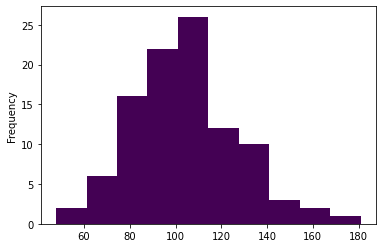

In [1289]:
#Final Simulated Price Distribution
print('\nChart 2 : Distribution of the final simulated prices')
MC(S0,E,r,sigma,T,dt,100).simulate().iloc[-1,:].plot(kind='hist',cmap='viridis')
plt.show()


Chart 3 : Distribution of payoffs


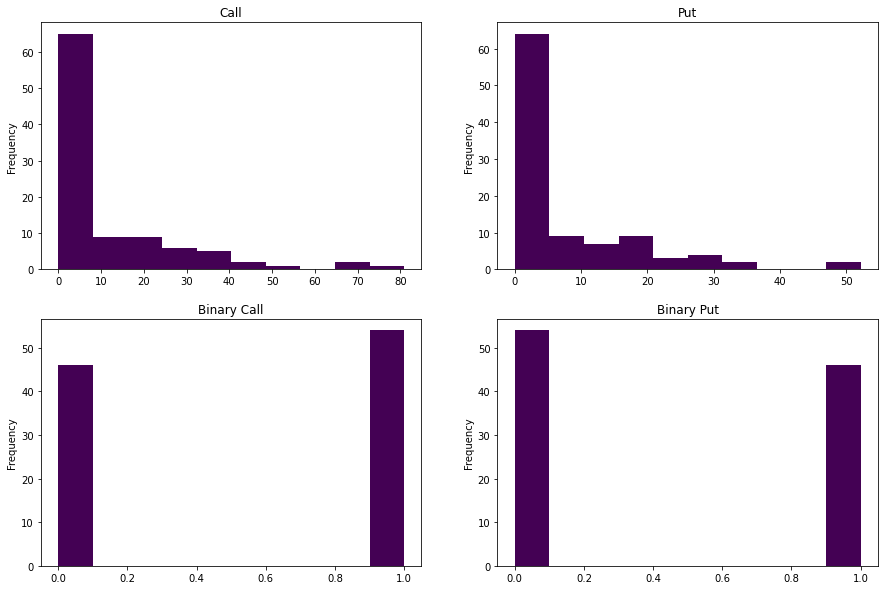

In [1290]:
#Payoffs
print('\nChart 3 : Distribution of payoffs')

fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(15,10))
MC(S0,E,r,sigma,T,dt,100).payoffs().payoff_c.plot(kind='hist',cmap='viridis',ax=ax[0,0])
MC(S0,E,r,sigma,T,dt,100).payoffs().payoff_p.plot(kind='hist',cmap='viridis',ax=ax[0,1])
MC(S0,E,r,sigma,T,dt,100).payoffs().payoff_bc.plot(kind='hist',cmap='viridis',ax=ax[1,0])
MC(S0,E,r,sigma,T,dt,100).payoffs().payoff_bp.plot(kind='hist',cmap='viridis',ax=ax[1,1])

ax[0,0].set_title('Call')
ax[0,1].set_title('Put')
ax[1,0].set_title('Binary Call')
ax[1,1].set_title('Binary Put')

plt.show()

In [1291]:
#Check prices by instantiating the MC class

binaryCall_mc=MC(S0,E,r,sigma,T,dt,N).binarycallPrice()
binaryPut_mc=MC(S0,E,r,sigma,T,dt,N).binaryputPrice()

print('\n***Option prices using Monte Carlo***\n')
print('Binary Call price: ', binaryCall_mc)
print('Binary Put price: ', binaryPut_mc)
print('\n')


***Option prices using Monte Carlo***

Binary Call price:  0.5136638892303856
Binary Put price:  0.4375655352703285




## Comparison wth Black Scholes Option Pricing Formula

In [1292]:
#Black Scholes Class for Reference

class BS:

    def __init__(self,spot,strike,r,sigma,tou):
        self.spot=spot
        self.strike=strike
        self.r=r
        self.tou=tou
        self.sigma=sigma
        self.d1=(np.log(self.spot/self.strike)+(self.r+0.5*self.sigma*self.sigma)*self.tou)/(self.sigma*np.sqrt(self.tou))
        self.d2=(np.log(self.spot/self.strike)+(self.r-0.5*self.sigma*self.sigma)*self.tou)/(self.sigma*np.sqrt(self.tou))
    
    def callPrice(self):
        call=self.spot*norm.cdf(self.d1)-self.strike*np.exp(-self.r*self.tou)*norm.cdf(self.d2)
        return call
    
    def putPrice(self):
        put=-self.spot*norm.cdf(-self.d1)+self.strike*np.exp(-self.r*self.tou)*norm.cdf(-self.d2)
        return put
    
    def binarycallPrice(self):
        bcall=np.exp(-self.r*self.tou)*norm.cdf(self.d2)
        return bcall
    
    def binaryputPrice(self):
        bput=np.exp(-self.r*self.tou)*(1-norm.cdf(self.d2))
        return bput
    

In [1293]:
#Check prices by instantiating the BS class

binaryCall_bs=BS(S0,E,r,sigma,T).binarycallPrice()
binaryPut_bs=BS(S0,E,r,sigma,T).binaryputPrice()

print('\n***Option prices using Black Scholes***\n')
print('Binary Call price: ', binaryCall_bs)
print('Binary Put price: ', binaryPut_bs)
print('\n')


***Option prices using Black Scholes***

Binary Call price:  0.5323248154537634
Binary Put price:  0.41890460904695065




In [1294]:
#Comparison table

#Case 0: Base Case with default parameters

call_MC=MC(S0,E,r,sigma,T,dt,N).callPrice()
call_BS=BS(S0,E,r,sigma,T).callPrice()

put_MC=MC(S0,E,r,sigma,T,dt,N).putPrice()
put_BS=BS(S0,E,r,sigma,T).putPrice()

binaryCall_MC=MC(S0,E,r,sigma,T,dt,N).binarycallPrice()
binaryCall_BS=BS(S0,E,r,sigma,T).binarycallPrice()

binaryPut_MC=MC(S0,E,r,sigma,T,dt,N).binaryputPrice()
binaryPut_BS=BS(S0,E,r,sigma,T).binaryputPrice()

print('\nTable 1: Pricing of different options (Base Case):\n')

print(tabulate.tabulate([['Call',S0,E,r,sigma,T,dt,N,call_MC,call_BS,abs(call_MC/call_BS-1)*100],
                         ['Put',S0,E,r,sigma,T,dt,N,put_MC,put_BS,abs(put_MC/put_BS-1)*100],
                         ['Binary Call',S0,E,r,sigma,T,dt,N,binaryCall_MC,binaryCall_BS,abs(binaryCall_MC/binaryCall_BS-1)*100],
                         ['Binary Put',S0,E,r,sigma,T,dt,N,binaryPut_MC,binaryPut_BS,abs(binaryPut_MC/binaryPut_BS-1)*100],
                        ],headers=['Option','Spot','Strike','r','Vol','Time to expiry','timestep','No. of simulations','Monte Carlo','Black Scholes','Diff %']))
print('\n')



Table 1: Pricing of different options (Base Case):

Option         Spot    Strike     r    Vol    Time to expiry    timestep    No. of simulations    Monte Carlo    Black Scholes    Diff %
-----------  ------  --------  ----  -----  ----------------  ----------  --------------------  -------------  ---------------  --------
Call            100       100  0.05    0.2                 1        0.01                   100      10.3189          10.4506     1.26038
Put             100       100  0.05    0.2                 1        0.01                   100       6.53401          5.57353   17.2329
Binary Call     100       100  0.05    0.2                 1        0.01                   100       0.513664         0.532325   3.50555
Binary Put      100       100  0.05    0.2                 1        0.01                   100       0.437566         0.418905   4.4547




## Effect of changing parameters on Option prices

### 1. Changing the Spot price/Time to Expiry


100%|██████████| 2/2 [00:44<00:00, 22.40s/it]



Table 2a: Effect of different Prices/Expiries on Binary Call Prices:

Option         Spot    Strike     r    Vol    Time to expiry    timestep    No. of simulations    Monte Carlo    Black Scholes         Diff
-----------  ------  --------  ----  -----  ----------------  ----------  --------------------  -------------  ---------------  -----------
Binary Call      30       100  0.05    0.2              1           0.01                   100     0               2.07441e-09  2.07441e-09
Binary Call      40       100  0.05    0.2              1           0.01                   100     0               4.45175e-06  4.45175e-06
Binary Call      50       100  0.05    0.2              1           0.01                   100     0               0.000434722  0.000434722
Binary Call      60       100  0.05    0.2              1           0.01                   100     0.00951229      0.00771023   0.00180206
Binary Call      70       100  0.05    0.2              1           0.01                  

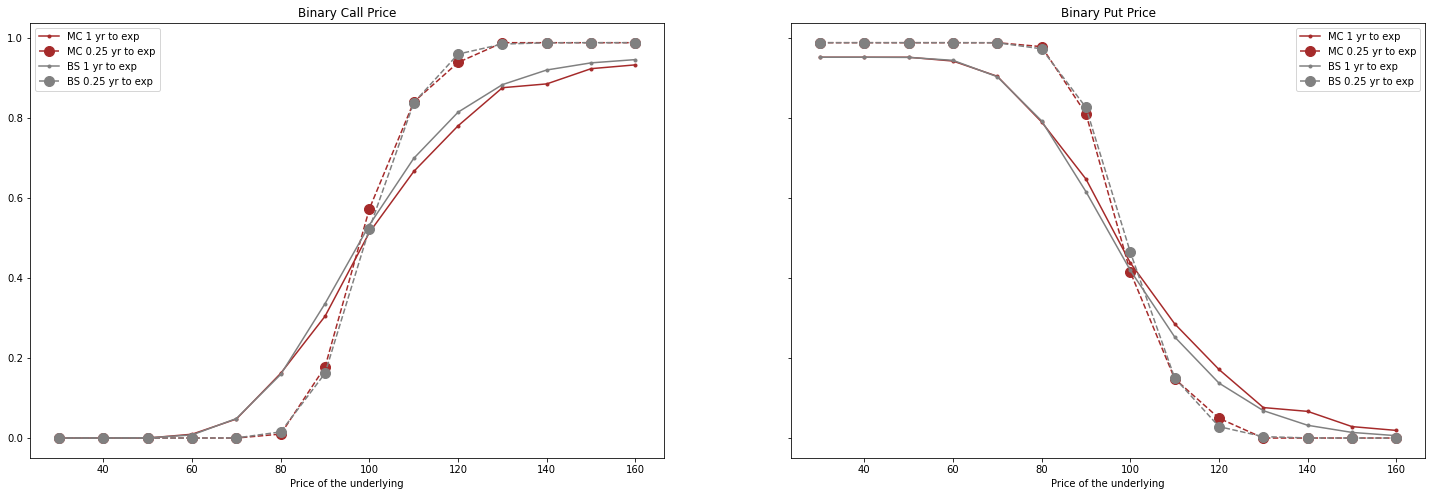

In [1295]:
#Case 1: Different S with rest of the parameters fixed

tables1=[]
tables2=[]

df1=pd.DataFrame(columns=['Option','Spot','Strike','r','Vol','Time to expiry','timestep','No. of simulations','Monte Carlo','Black Scholes','Diff'])

for tou in tqdm.tqdm([1,0.25]):
    
    for s in np.arange(30,170,10):
           
        binaryCall_MC=MC(s,E,r,sigma,tou,dt,N).binarycallPrice()
        binaryCall_BS=BS(s,E,r,sigma,tou).binarycallPrice()

        binaryPut_MC=MC(s,E,r,sigma,tou,dt,N).binaryputPrice()
        binaryPut_BS=BS(s,E,r,sigma,tou).binaryputPrice()

        df1=df1.append(pd.Series(['Binary Call',s,E,r,sigma,tou,dt,N,binaryCall_MC,binaryCall_BS,abs(binaryCall_MC-binaryCall_BS)],index=df1.columns),ignore_index=True)
        df1=df1.append(pd.Series(['Binary Put',s,E,r,sigma,tou,dt,N,binaryPut_MC,binaryPut_BS,abs(binaryPut_MC-binaryPut_BS)],index=df1.columns),ignore_index=True)

        tables1.append(['Binary Call',s,E,r,sigma,tou,dt,N,binaryCall_MC,binaryCall_BS,abs(binaryCall_MC-binaryCall_BS)])
        tables2.append(['Binary Put',s,E,r,sigma,tou,dt,N,binaryPut_MC,binaryPut_BS,abs(binaryPut_MC-binaryPut_BS)])

print('\nTable 2a: Effect of different Prices/Expiries on Binary Call Prices:\n')
print(tabulate.tabulate([table for table in tables1],headers=['Option','Spot','Strike','r','Vol','Time to expiry','timestep','No. of simulations','Monte Carlo','Black Scholes','Diff']))
print('\n')

print('\nTable 2b: Effect of different Prices/Expiries on Binary Put Prices:\n')
print(tabulate.tabulate([table for table in tables2],headers=['Option','Spot','Strike','r','Vol','Time to expiry','timestep','No. of simulations','Monte Carlo','Black Scholes','Diff']))
print('\n')

#Plot
print('\nChart 4 : Effect of different initial prices')
fig,ax=plt.subplots(1,2, figsize=(25,8), sharey=True)
x=np.arange(30,170,10)
ax[0].plot(x, df1[(df1.Option=='Binary Call') & (df1['Time to expiry']==1)]['Monte Carlo'].tolist(),label='MC 1 yr to exp',color='brown',marker='.')
ax[0].plot(x, df1[(df1.Option=='Binary Call') & (df1['Time to expiry']==0.25)]['Monte Carlo'].tolist(),label='MC 0.25 yr to exp',color='brown',marker='o',linestyle='dashed',markersize=10)
ax[0].plot(x, df1[(df1.Option=='Binary Call') & (df1['Time to expiry']==1)]['Black Scholes'].tolist(),label='BS 1 yr to exp',color='grey',marker='.')
ax[0].plot(x, df1[(df1.Option=='Binary Call') & (df1['Time to expiry']==0.25)]['Black Scholes'].tolist(),label='BS 0.25 yr to exp',color='grey',marker='o',linestyle='dashed',markersize=10)

ax[1].plot(x, df1[(df1.Option=='Binary Put') & (df1['Time to expiry']==1)]['Monte Carlo'].tolist(),label='MC 1 yr to exp',color='brown',marker='.')
ax[1].plot(x, df1[(df1.Option=='Binary Put') & (df1['Time to expiry']==0.25)]['Monte Carlo'].tolist(),label='MC 0.25 yr to exp',color='brown',marker='o',linestyle='dashed',markersize=10)
ax[1].plot(x, df1[(df1.Option=='Binary Put') & (df1['Time to expiry']==1)]['Black Scholes'].tolist(),label='BS 1 yr to exp',color='grey',marker='.')
ax[1].plot(x, df1[(df1.Option=='Binary Put') & (df1['Time to expiry']==0.25)]['Black Scholes'].tolist(),label='BS 0.25 yr to exp',color='grey',marker='o',linestyle='dashed',markersize=10)

ax[0].set_title('Binary Call Price'),ax[1].set_title('Binary Put Price')
ax[0].legend(),ax[1].legend()
ax[0].set_xlabel('Price of the underlying'),ax[1].set_xlabel('Price of the underlying')
plt.show()

#### Comment: The out of money option becomes less valuable (for a given spot price of the underlying) as it approaches expiry.

### 2. Changing the risk free rate


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]



Table 3a: Effect of r on Binary Call Prices:

Option         Spot    Strike      r    Vol    Time to expiry    timestep    No. of simulations    Monte Carlo    Black Scholes         Diff
-----------  ------  --------  -----  -----  ----------------  ----------  --------------------  -------------  ---------------  -----------
Binary Call     100       100  0        0.2                 1        0.01                   100       0.42             0.460172  0.0401722
Binary Call     100       100  0.005    0.2                 1        0.01                   100       0.437805         0.467763  0.0299572
Binary Call     100       100  0.01     0.2                 1        0.01                   100       0.455423         0.475285  0.0198616
Binary Call     100       100  0.015    0.2                 1        0.01                   100       0.482705         0.482732  2.70727e-05
Binary Call     100       100  0.02     0.2                 1        0.01                   100       0.499901   

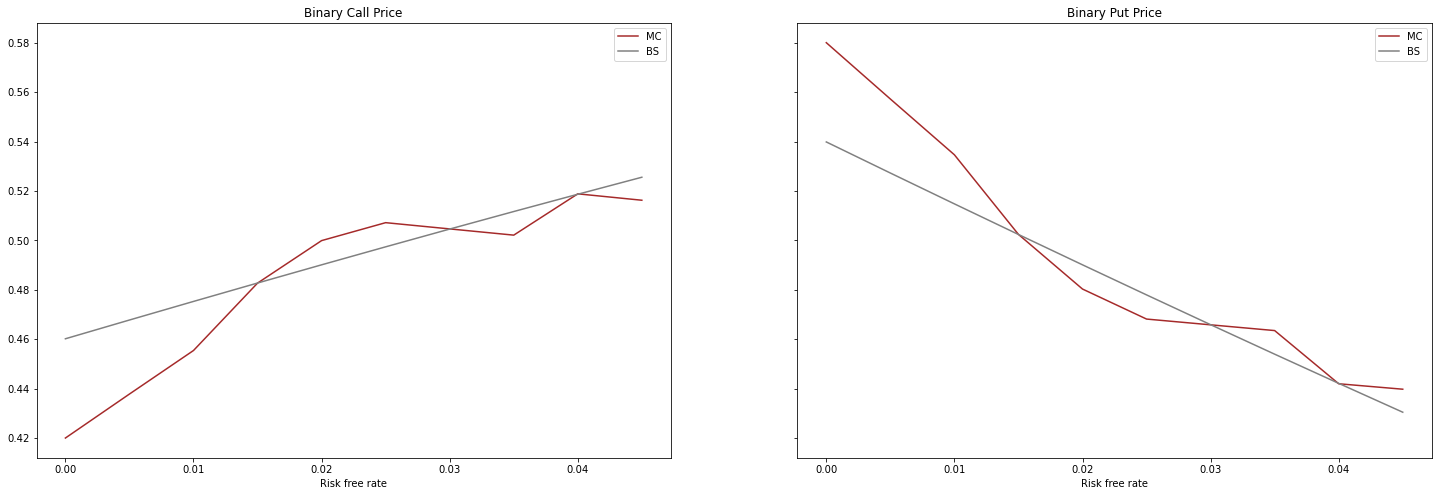

In [1296]:
#Case 2: Different r with rest of the parameters fixed

tables1=[]
tables2=[]

df2=pd.DataFrame(columns=['Option','Spot','Strike','r','Vol','Time to expiry','timestep','No. of simulations','Monte Carlo','Black Scholes','Diff'])

for r_ in tqdm.tqdm(np.arange(0,0.05,0.005)):

    binaryCall_MC=MC(S0,E,r_,sigma,T,dt,N).binarycallPrice()
    binaryCall_BS=BS(S0,E,r_,sigma,T).binarycallPrice()

    binaryPut_MC=MC(S0,E,r_,sigma,T,dt,N).binaryputPrice()
    binaryPut_BS=BS(S0,E,r_,sigma,T).binaryputPrice()
    
    df2=df2.append(pd.Series(['Binary Call',S0,E,r_,sigma,T,dt,N,binaryCall_MC,binaryCall_BS,abs(binaryCall_MC-binaryCall_BS)],index=df2.columns),ignore_index=True)
    df2=df2.append(pd.Series(['Binary Put',S0,E,r_,sigma,T,dt,N,binaryPut_MC,binaryPut_BS,abs(binaryPut_MC-binaryPut_BS)],index=df2.columns),ignore_index=True)
    
    tables1.append(['Binary Call',S0,E,r_,sigma,T,dt,N,binaryCall_MC,binaryCall_BS,abs(binaryCall_MC-binaryCall_BS)])
    tables2.append(['Binary Put',S0,E,r_,sigma,T,dt,N,binaryPut_MC,binaryPut_BS,abs(binaryPut_MC-binaryPut_BS)])

print('\nTable 3a: Effect of r on Binary Call Prices:\n')
print(tabulate.tabulate([table for table in tables1],headers=['Option','Spot','Strike','r','Vol','Time to expiry','timestep','No. of simulations','Monte Carlo','Black Scholes','Diff']))
print('\n')

print('\nTable 3b: Effect of r on Binary Put Prices:\n')
print(tabulate.tabulate([table for table in tables2],headers=['Option','Spot','Strike','r','Vol','Time to expiry','timestep','No. of simulations','Monte Carlo','Black Scholes','Diff']))
print('\n')

#Plot
print('\nChart 5 : Effect of different risk-free rates')
fig,ax=plt.subplots(1,2, figsize=(25,8), sharey=True)
x=np.arange(0,0.05,0.005)
ax[0].plot(x, df2[df2.Option=='Binary Call']['Monte Carlo'].tolist(),label='MC',color='brown')
ax[0].plot(x, df2[df2.Option=='Binary Call']['Black Scholes'].tolist(),label='BS',color='grey')
ax[1].plot(x, df2[df2.Option=='Binary Put']['Monte Carlo'].tolist(),label='MC',color='brown')
ax[1].plot(x, df2[df2.Option=='Binary Put']['Black Scholes'].tolist(),label='BS',color='grey')
ax[0].set_title('Binary Call Price'),ax[1].set_title('Binary Put Price')
ax[0].legend(),ax[1].legend()
ax[0].set_xlabel('Risk free rate'),ax[1].set_xlabel('Risk free rate')
plt.show()

#### Comment: Increasing r raises the call price and lowers the put price

### 3. Changing the number of simulations


100%|██████████| 5/5 [01:00<00:00, 12.17s/it]



Chart 6a : Effect of different no. of simulations


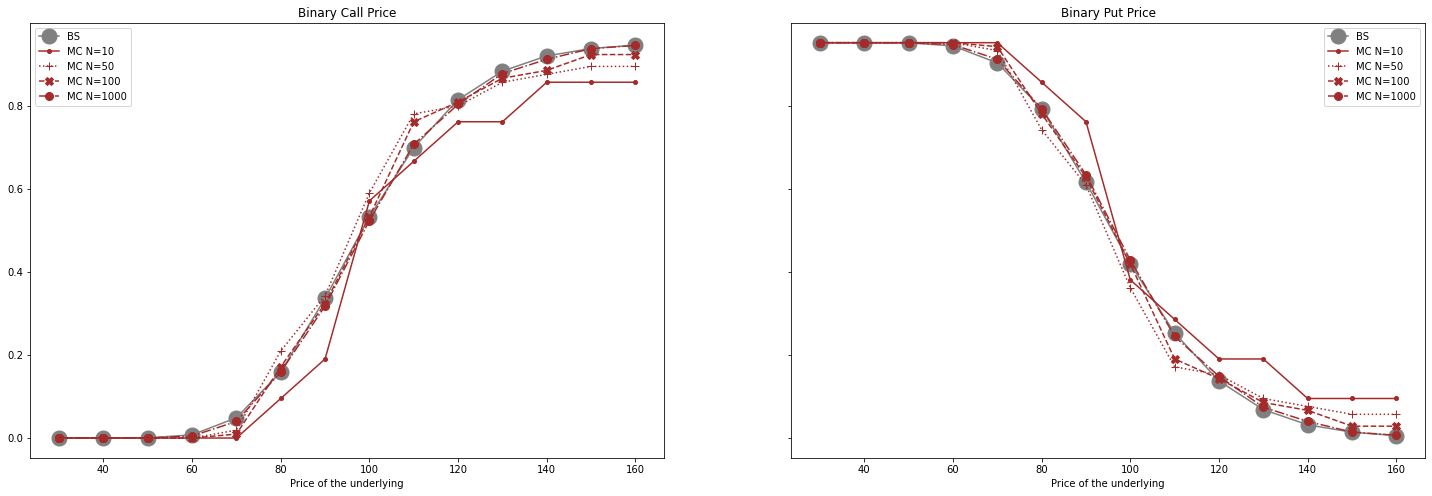

In [1297]:
#Case 3: Different N/S with rest of the parameters fixed

dt=0.1

# tables1=[]
# tables2=[]

df3=pd.DataFrame(columns=['Option','Spot','Strike','r','Vol','Time to expiry','timestep','No. of simulations','Monte Carlo','Black Scholes','Diff'])

for N_ in tqdm.tqdm([10,50,100,500,1000]):
    
    for s in (np.arange(30,170,10)):
           
        binaryCall_MC=MC(s,E,r,sigma,T,dt,N_).binarycallPrice()
        binaryCall_BS=BS(s,E,r,sigma,T).binarycallPrice()

        binaryPut_MC=MC(s,E,r,sigma,T,dt,N_).binaryputPrice()
        binaryPut_BS=BS(s,E,r,sigma,T).binaryputPrice()

        df3=df3.append(pd.Series(['Binary Call',s,E,r,sigma,T,dt,N_,binaryCall_MC,binaryCall_BS,abs(binaryCall_MC-binaryCall_BS)],index=df3.columns),ignore_index=True)
        df3=df3.append(pd.Series(['Binary Put',s,E,r,sigma,T,dt,N_,binaryPut_MC,binaryPut_BS,abs(binaryPut_MC-binaryPut_BS)],index=df3.columns),ignore_index=True)

        tables1.append(['Binary Call',s,E,r,sigma,T,dt,N_,binaryCall_MC,binaryCall_BS,abs(binaryCall_MC-binaryCall_BS)])
        tables2.append(['Binary Put',s,E,r,sigma,T,dt,N_,binaryPut_MC,binaryPut_BS,abs(binaryPut_MC-binaryPut_BS)])

# print('\nTable 4: Effect of different Prices/Expiries on Binary Call Prices:\n')
# print(tabulate.tabulate([table for table in tables1],headers=['Option','Spot','Strike','r','Vol','Time to expiry','timestep','No. of simulations','Monte Carlo','Black Scholes','Diff']))
# print('\n')

# print('\nTable 4b: Effect of different Prices/Expiries on Binary Put Prices:\n')
# print(tabulate.tabulate([table for table in tables2],headers=['Option','Spot','Strike','r','Vol','Time to expiry','timestep','No. of simulations','Monte Carlo','Black Scholes','Diff']))
# print('\n')

#Plot
print('\nChart 6a : Effect of different no. of simulations')
fig,ax=plt.subplots(1,2, figsize=(25,8), sharey=True)
x=np.arange(30,170,10)

ax[0].plot(x, df3[(df3.Option=='Binary Call') & (df3['No. of simulations']==10)]['Black Scholes'].tolist(),label='BS',color='grey',marker='o',markersize=15)
ax[0].plot(x, df3[(df3.Option=='Binary Call') & (df3['No. of simulations']==10)]['Monte Carlo'].tolist(),label='MC N=10',color='brown',marker='.',linestyle='solid',markersize=8)
ax[0].plot(x, df3[(df3.Option=='Binary Call') & (df3['No. of simulations']==50)]['Monte Carlo'].tolist(),label='MC N=50',color='brown',marker='+',linestyle='dotted',markersize=8)
ax[0].plot(x, df3[(df3.Option=='Binary Call') & (df3['No. of simulations']==100)]['Monte Carlo'].tolist(),label='MC N=100',color='brown',marker='X',linestyle='dashed',markersize=8)
ax[0].plot(x, df3[(df3.Option=='Binary Call') & (df3['No. of simulations']==1000)]['Monte Carlo'].tolist(),label='MC N=1000',color='brown',marker='o',linestyle='dashdot',markersize=8)

ax[1].plot(x, df3[(df3.Option=='Binary Put') & (df3['No. of simulations']==10)]['Black Scholes'].tolist(),label='BS',color='grey',marker='o',markersize=15)
ax[1].plot(x, df3[(df3.Option=='Binary Put') & (df3['No. of simulations']==10)]['Monte Carlo'].tolist(),label='MC N=10',color='brown',marker='.',linestyle='solid',markersize=8)
ax[1].plot(x, df3[(df3.Option=='Binary Put') & (df3['No. of simulations']==50)]['Monte Carlo'].tolist(),label='MC N=50',color='brown',marker='+',linestyle='dotted',markersize=8)
ax[1].plot(x, df3[(df3.Option=='Binary Put') & (df3['No. of simulations']==100)]['Monte Carlo'].tolist(),label='MC N=100',color='brown',marker='X',linestyle='dashed',markersize=8)
ax[1].plot(x, df3[(df3.Option=='Binary Put') & (df3['No. of simulations']==1000)]['Monte Carlo'].tolist(),label='MC N=1000',color='brown',marker='o',linestyle='dashdot',markersize=8)

ax[0].set_title('Binary Call Price'),ax[1].set_title('Binary Put Price')
ax[0].legend(),ax[1].legend()
ax[0].set_xlabel('Price of the underlying'),ax[1].set_xlabel('Price of the underlying')
plt.show()

In [1298]:
#Error Lines

binaryCall_BS=BS(S0,E,r,sigma,T).binarycallPrice()
binaryPut_BS=BS(S0,E,r,sigma,T).binaryputPrice()

err1_c=pd.DataFrame(columns=['N','mean','std','se'])
err1_p=pd.DataFrame(columns=['N','mean','std','se'])

for N_ in tqdm.tqdm([10,50,100,500,1000,5000]):
    
    mean=MC(S0,E,r,sigma,T,dt,N_).payoffs().payoff_bc.apply(lambda x:np.exp(-r*T)*x).mean()
    std=MC(S0,E,r,sigma,T,dt,N_).payoffs().payoff_bc.apply(lambda x:np.exp(-r*T)*x).std()
    se=std/np.sqrt(N_)
    err1_c=err1_c.append(pd.Series([str(N_),mean,std,se],index=err1_c.columns),ignore_index=True)

    mean=MC(S0,E,r,sigma,T,dt,N_).payoffs().payoff_bp.apply(lambda x:np.exp(-r*T)*x).mean()
    std=MC(S0,E,r,sigma,T,dt,N_).payoffs().payoff_bp.apply(lambda x:np.exp(-r*T)*x).std()
    se=std/np.sqrt(N_)
    err1_p=err1_p.append(pd.Series([str(N_),mean,std,se],index=err1_p.columns),ignore_index=True)



100%|██████████| 6/6 [00:34<00:00,  5.77s/it]



Chart 6b


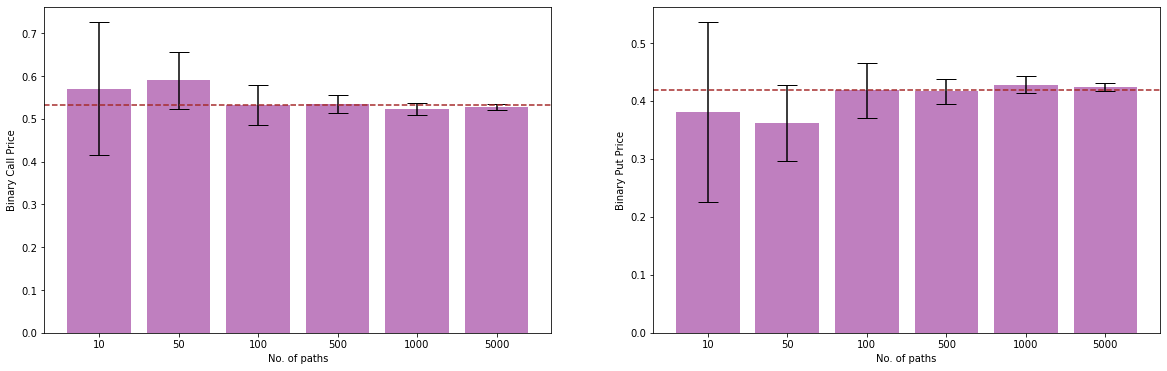

In [1299]:
print('\nChart 6b')

fig,ax = plt.subplots(1,2,figsize=(20,6))

ax[0].bar(err1_c['N'],err1_c['mean'],yerr=err1_c['se'],align='center',alpha=0.5,capsize=10,color='purple')
ax[0].axhline(binaryCall_BS,color='brown',linestyle='--')
ax[0].set_xlabel('No. of paths')
ax[0].set_ylabel('Binary Call Price')

ax[1].bar(err1_p['N'],err1_p['mean'],yerr=err1_p['se'],align='center',alpha=0.5,capsize=10,color='purple')
ax[1].axhline(binaryPut_BS,color='brown',linestyle='--')
ax[1].set_xlabel('No. of paths')
ax[1].set_ylabel('Binary Put Price')

plt.show()

#### Comment: Increasing N increases accuracy

### 4. Changing the timestep


100%|██████████| 4/4 [06:32<00:00, 98.11s/it]



Chart 7a : Effect of different timesteps


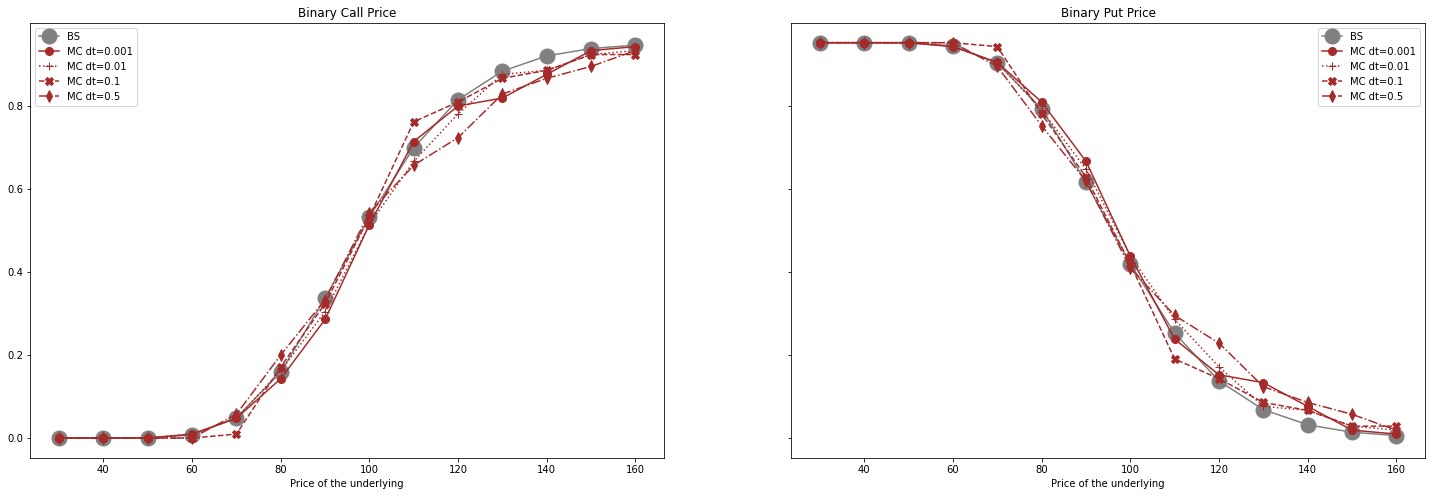

In [1300]:
#Case 4: Different dt with rest of the parameters fixed

N=100
dt=0.01

df4=pd.DataFrame(columns=['Option','Spot','Strike','r','Vol','Time to expiry','timestep','No. of simulations','Monte Carlo','Black Scholes','Diff'])

for dt_ in tqdm.tqdm([0.001,0.01,0.1,0.5]):
    
    for s in np.arange(30,170,10):
           
        binaryCall_MC=MC(s,E,r,sigma,T,dt_,N).binarycallPrice()
        binaryCall_BS=BS(s,E,r,sigma,T).binarycallPrice()

        binaryPut_MC=MC(s,E,r,sigma,T,dt_,N).binaryputPrice()
        binaryPut_BS=BS(s,E,r,sigma,T).binaryputPrice()

        df4=df4.append(pd.Series(['Binary Call',s,E,r,sigma,T,dt_,N,binaryCall_MC,binaryCall_BS,abs(binaryCall_MC-binaryCall_BS)],index=df4.columns),ignore_index=True)
        df4=df4.append(pd.Series(['Binary Put',s,E,r,sigma,T,dt_,N,binaryPut_MC,binaryPut_BS,abs(binaryPut_MC-binaryPut_BS)],index=df4.columns),ignore_index=True)

        tables1.append(['Binary Call',s,E,r,sigma,T,dt_,N,binaryCall_MC,binaryCall_BS,abs(binaryCall_MC-binaryCall_BS)])
        tables2.append(['Binary Put',s,E,r,sigma,T,dt_,N,binaryPut_MC,binaryPut_BS,abs(binaryPut_MC-binaryPut_BS)])

# print('\nTable 4: Effect of different Prices/Expiries on Binary Call Prices:\n')
# print(tabulate.tabulate([table for table in tables1],headers=['Option','Spot','Strike','r','Vol','Time to expiry','timestep','No. of simulations','Monte Carlo','Black Scholes','Diff']))
# print('\n')

# print('\nTable 4b: Effect of different Prices/Expiries on Binary Put Prices:\n')
# print(tabulate.tabulate([table for table in tables2],headers=['Option','Spot','Strike','r','Vol','Time to expiry','timestep','No. of simulations','Monte Carlo','Black Scholes','Diff']))
# print('\n')

#Plot
print('\nChart 7a : Effect of different timesteps')
fig,ax=plt.subplots(1,2, figsize=(25,8), sharey=True)
x=np.arange(30,170,10)

ax[0].plot(x, df4[(df4.Option=='Binary Call') & (df4['timestep']==0.1)]['Black Scholes'].tolist(),label='BS',color='grey',marker='o',markersize=15)
ax[0].plot(x, df4[(df4.Option=='Binary Call') & (df4['timestep']==0.001)]['Monte Carlo'].tolist(),label='MC dt=0.001',color='brown',marker='o',linestyle='solid',markersize=8)
ax[0].plot(x, df4[(df4.Option=='Binary Call') & (df4['timestep']==0.01)]['Monte Carlo'].tolist(),label='MC dt=0.01',color='brown',marker='+',linestyle='dotted',markersize=8)
ax[0].plot(x, df4[(df4.Option=='Binary Call') & (df4['timestep']==0.1)]['Monte Carlo'].tolist(),label='MC dt=0.1',color='brown',marker='X',linestyle='dashed',markersize=8)
ax[0].plot(x, df4[(df4.Option=='Binary Call') & (df4['timestep']==0.5)]['Monte Carlo'].tolist(),label='MC dt=0.5',color='brown',marker='d',linestyle='dashdot',markersize=8)

ax[1].plot(x, df4[(df4.Option=='Binary Put') & (df4['timestep']==0.1)]['Black Scholes'].tolist(),label='BS',color='grey',marker='o',markersize=15)
ax[1].plot(x, df4[(df4.Option=='Binary Put') & (df4['timestep']==0.001)]['Monte Carlo'].tolist(),label='MC dt=0.001',color='brown',marker='o',linestyle='solid',markersize=8)
ax[1].plot(x, df4[(df4.Option=='Binary Put') & (df4['timestep']==0.01)]['Monte Carlo'].tolist(),label='MC dt=0.01',color='brown',marker='+',linestyle='dotted',markersize=8)
ax[1].plot(x, df4[(df4.Option=='Binary Put') & (df4['timestep']==0.1)]['Monte Carlo'].tolist(),label='MC dt=0.1',color='brown',marker='X',linestyle='dashed',markersize=8)
ax[1].plot(x, df4[(df4.Option=='Binary Put') & (df4['timestep']==0.5)]['Monte Carlo'].tolist(),label='MC dt=0.5',color='brown',marker='d',linestyle='dashdot',markersize=8)


ax[0].set_title('Binary Call Price'),ax[1].set_title('Binary Put Price')
ax[0].legend(),ax[1].legend()
ax[0].set_xlabel('Price of the underlying'),ax[1].set_xlabel('Price of the underlying')
plt.show()

In [1301]:
#Error Lines

N_=10000

binaryCall_BS=BS(S0,E,r,sigma,T).binarycallPrice()
binaryPut_BS=BS(S0,E,r,sigma,T).binaryputPrice()

err2_c=pd.DataFrame(columns=['Timestep','mean','std','se'])
err2_p=pd.DataFrame(columns=['Timestep','mean','std','se'])

for dt_ in tqdm.tqdm([0.5,0.4,0.3,0.2,0.1,0.05]):
    
    mean=MC(S0,E,r,sigma,T,dt_,N_).payoffs().payoff_bc.apply(lambda x:np.exp(-r*T)*x).mean()
    std=MC(S0,E,r,sigma,T,dt_,N_).payoffs().payoff_bc.apply(lambda x:np.exp(-r*T)*x).std()
    se=std/np.sqrt(N_)
    err2_c=err2_c.append(pd.Series([str(dt_),mean,std,se],index=err2_c.columns),ignore_index=True)

    mean=MC(S0,E,r,sigma,T,dt_,N_).payoffs().payoff_bp.apply(lambda x:np.exp(-r*T)*x).mean()
    std=MC(S0,E,r,sigma,T,dt_,N_).payoffs().payoff_bp.apply(lambda x:np.exp(-r*T)*x).std()
    se=std/np.sqrt(N_)
    err2_p=err2_p.append(pd.Series([str(dt_),mean,std,se],index=err2_p.columns),ignore_index=True)



100%|██████████| 6/6 [03:33<00:00, 35.52s/it]



Chart 7b


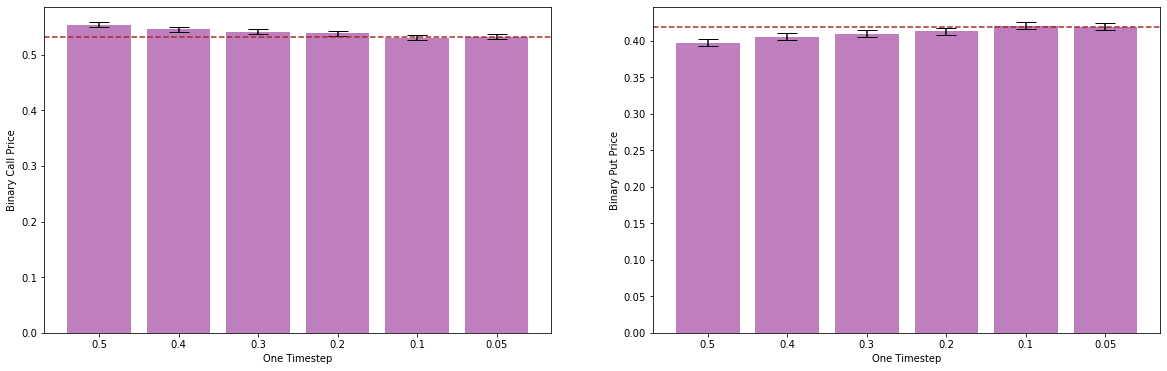

In [1302]:
print('\nChart 7b')

fig,ax = plt.subplots(1,2,figsize=(20,6))

ax[0].bar(err2_c['Timestep'],err2_c['mean'],yerr=err2_c['se'],align='center',alpha=0.5,capsize=10,color='purple')
ax[0].axhline(binaryCall_BS,color='brown',linestyle='--')
ax[0].set_xlabel('One Timestep')
ax[0].set_ylabel('Binary Call Price')

ax[1].bar(err2_p['Timestep'],err2_p['mean'],yerr=err2_p['se'],align='center',alpha=0.5,capsize=10,color='purple')
ax[1].axhline(binaryPut_BS,color='brown',linestyle='--')
ax[1].set_xlabel('One Timestep')
ax[1].set_ylabel('Binary Put Price')

plt.show()

#### Comment: Effect of the timestep is not as pronounced as seen with the number of paths.

## Errors and Computation Time

<li>As seen in the charts in the last two sections above, the error $\epsilon$ in the MC computations depends on the timestep $\delta$t (due to the discretized form of the SDE) and the number of simulations N (finite number of simulations).
<li>The error scales directly with $\delta$t and inversely to the square root of N. i.e., $\epsilon$ $\alpha$ $O$($\delta$t) and $\epsilon$ $\alpha$ $O$(N$^{-1/2}$)
<li>Computation time is of the order of $O$($\epsilon$$^{-3}$), which is proportional to the number of calculations.
<li>This implies that reducing the error by half would take 8 times as long.
<li>This is demonstrated below using the MC pricing of a binary call.

In [1303]:
df=pd.DataFrame(columns=['N','dt','Computation Time','SE'])

Ns=[10,50,100,500,1000,5000,10000,50000,100000]

for i in tqdm.tqdm(range(len(Ns))):
    t1=datetime.datetime.now()
    binaryCall_MC=MC(S0,E,r,sigma,T,dt,int(Ns[i])).binarycallPrice()
    t2=datetime.datetime.now()
    
    std=MC(S0,E,r,sigma,T,dt,Ns[i]).payoffs().payoff_bc.apply(lambda x:np.exp(-r*T)*x).std()
    se=std/np.sqrt(Ns[i])
    
    time=(t2-t1).seconds
    
    df=df.append(pd.Series([Ns[i],dt,time,se],index=df.columns),ignore_index=True)


100%|██████████| 9/9 [1:14:54<00:00, 499.37s/it] 


In [1304]:
print('\nTable 4 : Accuracies and Computation Time\n')
df


Table 4 : Accuracies and Computation Time



,N,dt,Computation Time,SE
0,10.0,0.01,0.0,0.155335
1,50.0,0.01,0.0,0.067070
2,100.0,0.01,1.0,0.047648
3,500.0,0.01,6.0,0.021116
4,1000.0,0.01,12.0,0.014950
5,5000.0,0.01,65.0,0.006669
6,10000.0,0.01,132.0,0.004716
7,50000.0,0.01,674.0,0.002112
8,100000.0,0.01,1332.0,0.001493


In [1220]:
#Time check

t1=datetime.datetime.now()
binaryCall_MC=MC(S0,E,r,sigma,T,0.001,100000).binarycallPrice()
t2=datetime.datetime.now()

time=(t2-t1).seconds

In [1227]:
print(time/3600, 'hrs!!!')

3.952777777777778 hrs!!!


### Significance testing

The price convergence towards Black Scholes can be checked using Hypothesis testing.

H0: Mean Price of MC and BS are equal.

Ha: Mean Price of MC and BS are different.



In [1305]:
st=pd.DataFrame(columns=['N','MC','BS','pvalue'])

dt=0.1

s=100
for N_ in tqdm.tqdm([100,500,1000,2500,5000]):

    mc=MC(s,E,r,sigma,T,dt,N_).payoffs().payoff_bc.apply(lambda x:np.exp(-r*T)*x).tolist()
    bs=[BS(s,E,r,sigma,T).binarycallPrice()]*N_

    st=st.append(pd.Series([N_,np.mean(mc),np.mean(bs),np.round(ttest_ind(mc,bs)[1],4)],index=st.columns),ignore_index=True)
    
st


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


,N,MC,BS,pvalue
0,100.0,0.532688,0.532325,0.9939
1,500.0,0.534591,0.532325,0.9146
2,1000.0,0.523176,0.532325,0.5412
3,2500.0,0.536874,0.532325,0.6297
4,5000.0,0.527552,0.532325,0.4754


#### Comment: Null Hypothesis cannot be rejected.

## Results and Discussions

The effect of changing timesteps on the accuracy of the Monte Carlo calculations is not quite clear at fewer number of simulations (Chart 7). On the other hand, the accuracy does tend to increase as the number of simulations increases.
However, computation time is enormous for larger number of simulations. An N of 100000 and a time step of 0.001 (with 1 year to expiry) takes almost 4 hrs to run in Python.

Besides, the price convergence towards Black Scholes is quite evident at larger N. 


## Conclusion

Monte Carlo is an extremely useful and flexible numerical method for the pricing of options, and the mathematics needed can be very basic. However, the computations can be extremely slow and the number of simulations required to get higher accuracy can be extremely large. Besides, the method might not be useful in finding the greeks and in pricing early exercises.

## References

<span id="fn1">[1] Paul Wilmott Introduces Quantitative Finance </span> <br>
<span id="fn2">[2] https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method </span> <br>
<span id="fn3">[3] https://en.wikipedia.org/wiki/Heaviside_step_function </span> <br>